# Prioritized Experience replay

Experience replay is used in DQN algorithms to enable the agent to remember and reuse past experiences. This breaks correlations between adjacent experiences. Vanilla DQN samples experiences uniformly, but it would be more efficient to sample *important* samples more often than others. **Prioritized Experience Replay** managed to outperform previous approaches in 41 out of 49 games on the Atari Benchmark in 2016. 

- Experience Replay $\rightarrow$ liberate agent from processing experiences in same order
- Prioritized Experience Replay $\rightarrow$ liberate agent from processing transitions as frequent as they are occuring by using the TD-ERROR.

There are studies that indicate, that hippocampus of rodents replay (while awake, resting or sleep) experiences more often, when TD-Error high! (SOURCE)

There are two design choices:
- Which experiences to store?
- **Which experiences to replay?** (explored in this paper)

#### Blind Cliffwalk example

$$
A(S) = 'right', 'wrong'
$$

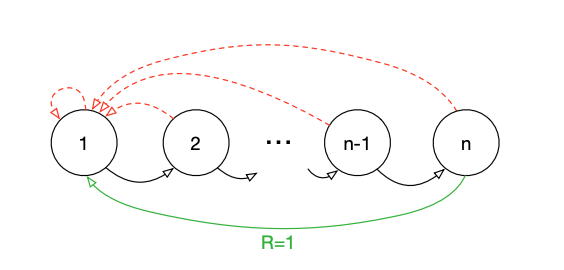

chance to get to $R=1$ at random: $2^{-n}$ $\rightarrow$ relevant transitions are rare, redundant failure cases occure frequently 

In [3]:
#tbd

#### Idea

Prioritize: Where can the agent learn the most? Mostly unkown, but TD-Error $\delta$ magnitude can be a reasonable proxy (HOW SUPRISING / UNEXPECTED IS A TRANSITION?). TD-Error can be bad also, when rewards are noisy(?)

**The Greedy TD-Error prioritization has some issues:**
- expensive sweeps over entire RM
    - only updated for transitions that are replayed BUT $\rightarrow$ low TD-error at first $\rightarrow$ will not be replayed for a long time (effictively never)
- sensitive to noise spikes (rewards stochastic)
- focuses on small subset of experience
    - errors shrink slowly, especielly when using function approximation. Initially high error transitions get replayed frequently $\rightarrow$ prone to overfitting

**These issues can be solved with a stochastic sampling method**, that interpolates between pure greedy prioritization and uniform random sampling. 

$$
P(i) = \frac{p_i^\alpha}{\sum_k{p_k^\alpha}},
$$
where $p_i > 0$ is priority of transition i and $\alpha$ being an parameter, regularizing how much priorizaton is used with $\alpha = 0$ drawing uniformely.

Two Variants:
1) $p_i = |\delta_i| + \epsilon $, where $\epsilon$ is a small positive constant, preventing edge case, when transitions not revisited once $|\delta_i| = 0$

2) $p_i = \frac{1}{rank(i)} $, where rank(i) is a rank of transition i, when sorted according to $|\delta_i|$

Variant 2 seems to be more robust to outliers.

# Code

In [1]:
import random
import numpy as np

In [1]:
#wrappers...
import cv2
import gym
import gym.spaces
import numpy as np
import collections


class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """
        For environments where the user need to press FIRE for the 
        game to start.
        """
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        #corner cases
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """
        Return only every `skip`-th frame
        """
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init. to first obs. from inner env."""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(
                np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(
                np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + \
              img[:, :, 2] * 0.114
        resized_screen = cv2.resize(
            img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        new_shape = (old_shape[-1], old_shape[0], old_shape[1])
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=new_shape, dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(
            old_space.low.repeat(n_steps, axis=0),
            old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(
            self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    #env = EpisodicLifeEnv(env)
    #env = ClipRewardEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)


In [2]:
from typing import Tuple, List, Union
from collections import namedtuple, deque

Experience = namedtuple("Experience", 
                       field_names = ["state", "action", "reward", "done", "next_state", "tderror"])


class ReplayMemory:
    """
    Replay Memory to store and sample experiences
    """
    def __init__(self, capacity: int) -> None:
        """
        Args:
            capacity: size of the buffer
        """
        self.buffer = deque(maxlen = capacity)
        
    def __len__(self):
        return len(self.buffer)
    
    def add(self, sample: Experience) -> None:
        """
        Adds an experience to the memory
        Args:
            sample: tuple(state, action, reward, done, new_state)
        """
        self.buffer.append(sample)
    
    def sample(self, batch_size:int = 1) -> Tuple:
        """
        returns a batch from the buffer, randomly! Samples Uniformly!
        Args:
            batch_size: size of the sample
        """
        #random
        idxs = np.random.choice(len(self), batch_size, replace=False)      
        
        states, actions, rewards, dones, next_states, td_error = \
                                    zip(*[self.buffer[idx] for idx in idxs])
        
        return np.array(states), np.array(actions), \
                np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.bool), \
                np.array(next_states)
    
    def calculate_pi(self, td_error, epsilon=0.00001):
        return td_error + epsilon
    
    def calculate_pi_alternative(self, td_error):
        pass
    
    def sample_prioritized(self, batch_size: int = 1, ALPHA=0.5):
        """
        Complexity N, is quite bad! (sum-tree is the key)
        """
        pi = np.array([calculate_pi(self.buffer[i].tderror) for i in range(len(buffer))])
        pi_sum = np.sum(pi**ALPHA)
        pi = pi**ALPHA / pi_sum

        idxs = np.random.choice(len(self), batch_size, replace=False, p=pi)
        
        states, actions, rewards, dones, next_states, td_error = \
                                    zip(*[self.buffer[idx] for idx in idxs])
        
        
        return np.array(states), np.array(actions), \
                np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.bool), \
                np.array(next_states)
    
def calculate_pi(tderror, epsilon = 0.0001):
    return tderror.item() + epsilon

def calculate_pi_alternative():
    pass
    


import torch
import torch.nn as nn
    
class DQN(nn.Module):
    """
    Neural Network, choosing actions
    """
    def __init__(self, n_in, n_out):
        super(DQN, self).__init__()
        #input is a 4x84x84 image
        self.conv = nn.Sequential(
            nn.Conv2d(n_in[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(n_in)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_out)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


In [4]:
import torch.optim as optim
import torch.nn.functional as F
import time
from torch.utils.tensorboard import SummaryWriter

RM_CAPACITY = 100000
GAMMA = 0.99
N_EPISODES = 1000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY_LAST_FRAME = 100000
LEARNING_RATE = 0.00001
MEMORY_START_SIZE = 10000
BATCH_SIZE = 32
TARGET_UPDATE_AFTER = 10000

overall_timesteps = 0
timesteps_tmp = 0 
obtained_returns = []
m_rewards = []


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
replay_memory = ReplayMemory(RM_CAPACITY)
ENV_NAME = "PongNoFrameskip-v4"
env = make_env(ENV_NAME)
target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
policy_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())


writer = SummaryWriter()
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)


def get_evaluation_states(n=5):
    states = []
    state = env.reset()
    for i in range(n):
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        states.append(len(next_state))
    return states
    

eval_states = get_evaluation_states(1000)

def calc_loss(batch, policy_net, target_net, device):
    states, actions, rewards, dones, next_states = batch
    
    states_v = torch.from_numpy(states).to(device)
    next_states_v = torch.from_numpy(next_states).to(device)
    actions_v = torch.from_numpy(actions).to(device)
    rewards_v = torch.from_numpy(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)
    
    state_action_values = policy_net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    
    with torch.no_grad():
        next_state_values = target_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()
    expected_state_action_values = (next_state_values * GAMMA) + rewards_v
    
    return F.smooth_l1_loss(state_action_values, expected_state_action_values)

for episode in range(N_EPISODES):
    break
    print("Start episode %d" % episode)
    state = env.reset()
    return_val = 0
    done=False
    ts = time.time()
    
    while(not done):
        epsilon = max(EPSILON_END, EPSILON_START - overall_timesteps / EPSILON_DECAY_LAST_FRAME)
        
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals = policy_net(torch.tensor(np.array([state], copy=False)).to(device))
            _, action = torch.max(q_vals, dim=1)
            action = action.item()
        
        next_state, reward, done, _ = env.step(action)
        
        
        
        with torch.no_grad():
            q_vals = target_net(torch.tensor(np.array([state], copy=False)).to(device))
            q_vals_next = target_net(torch.tensor(np.array([next_state], copy=False)).to(device))
            q_val_max = torch.max(q_vals_next).data

            td_error = reward + GAMMA*torch.max(q_vals).data - q_val_max
        
        return_val += reward
        
        exp = Experience(state, action, reward, done, next_state, torch.abs(td_error))
        replay_memory.add(exp)
        
        state = next_state

        if(len(replay_memory) > MEMORY_START_SIZE):
            optimizer.zero_grad()            
            batch = replay_memory.sample(BATCH_SIZE)
            loss = calc_loss(batch, policy_net, target_net, device=device)
            loss.backward()
            optimizer.step()
          
        
        if overall_timesteps % TARGET_UPDATE_AFTER == 0:
            print("Updating Targetnet")
            target_net.load_state_dict(policy_net.state_dict())
            
        
        overall_timesteps += 1
        
    speed = (overall_timesteps - timesteps_tmp) / (time.time() - ts)
    timesteps_tmp = overall_timesteps
    ts = time.time()
    
    print("Episode %d completed, timesteps played: %d, return: %d, speed: %f, epsilon: %f" 
                            % (episode, overall_timesteps, return_val, speed, epsilon))
    obtained_returns.append(return_val)
    m_reward = np.mean(obtained_returns[-100:])
    m_rewards.append(m_reward)
    writer.add_scalar('Atari/AvgTotalReward', m_reward, overall_timesteps / 50000)
    
    print("Mean return of last 100 games: %f" % m_reward)
writer.close()

The TD-ERROR can now be used to calculate priorization. Todo: Batches and training loop.